In [1]:
import os, sys, re
from itertools import islice 
import numpy as np
import pandas as pd
import hashlib
import random
import math
import json
from random import sample
from tqdm import tqdm
import IPython
from python_speech_features import mfcc
import scipy.io.wavfile as wav
import matplotlib.pyplot as plt

In [2]:
#keywords = ['people', 'something', 'little', 'hundred', 'important', 'problem', 'million', 
#            'technology', 'africa', 'science', 'community', 'government', 'challenge', 'major', 
#            'organization', 'london', 'washington', 'japanese', 'nigeria', 'england', 'germany',
#            'ingredients', 'rose', 'benjamin', 'kevin']

In [5]:
#non_keywords = ['outside', 'different', 'information', 'service', 
#                'seen', 'everything', 'collection', 'courses', 'insurance', 'issue', 
#                'bank', 'continue', 'specific', 'best', 'watch', 'report', 'cost','back', 
#                'was', 'here', 'their', 'will', 'went', 'have', 'what', 'which', 'with','that', 'this']


### Prepare data and compute features

In [2]:
words_1000 = [] 
with open('1000-midlong', 'r') as thousend_words:
    for word in thousend_words:
        words_1000.append(word.strip())

In [3]:
keywords = ['percent', 'world', 'today', 'people']

In [4]:
possible_non_keywords = list(set(words_1000) - set(keywords))

For the non keywords, we sample randomly 250 words from the database and limit the number of samples to one thousand per word.

In [5]:
non_keywords = sample(possible_non_keywords, k=250)

In [6]:
path = os.path.abspath("../../Datasets/TEDLIUM_release1/idiap_kw_db/")
filenames = []

for w in (keywords + non_keywords):
    current_path = os.path.join(path, w[0], w) 
    for _, _, files in os.walk(current_path):
        if w in non_keywords:
            if len(files)>1000:
                files = sample(files, k=1000)
        for file in files:
            filenames.append(os.path.join(current_path, file))

We load the .wav file and trim it to have **1 second long word** (append with zeros if signal length is less than 1 second). We compute **40 MFCC features** for each word. 

In [7]:
def compute_mfcc(signal, fs, threshold=1.0, num_features=40): 
    
    dur = len(signal)
    if dur < threshold * fs:
        zeros = np.zeros((int(threshold * fs) - dur, 1)).reshape(-1,)
        signal = np.concatenate((signal, zeros), axis=0)
    else:
        signal = signal[:fs]
    
    features = mfcc(signal, samplerate=fs, winlen=0.030, winstep=0.01, numcep=num_features,
                    lowfreq=20, highfreq=4000, appendEnergy=False, nfilt=num_features)
    
    return features

**Function to split the dataset into training, testing and validation**

In [8]:
MAX_NUM_WAVS_PER_CLASS = 2**27 - 1  # ~134M

def which_set(filename, validation_percentage, testing_percentage):
    """
    Determines which data partition the file should belong to.

    We want to keep files in the same training, validation, or testing sets even
    if new ones are added over time. This makes it less likely that testing
    samples will accidentally be reused in training when long runs are restarted
    for example. To keep this stability, a hash of the filename is taken and used
    to determine which set it should belong to. This determination only depends on
    the name and the set proportions, so it won't change as other files are added.

    It's also useful to associate particular files as related (for example words
    spoken by the same person), so anything after '_.' in a filename is
    ignored for set determination. This ensures that 'AdamSavage_2008P_5.wav' and
    'AdamSavage_2008P_0.wav' are always in the same set, for example.

    Args:
    filename: File path of the data sample.
    validation_percentage: How much of the data set to use for validation.
    testing_percentage: How much of the data set to use for testing.

    Returns:
    String, one of 'training', 'validation', or 'testing'.
    """
    
    kw = filename.split('/')[-2]
    base_name = kw + '-' + os.path.basename(filename).replace('_', '-', 1)
    # We want to ignore anything after '-' in the file name when
    # deciding which set to put a wav in, so the data set creator has a way of
    # grouping wavs that are close variations of each other.
    hash_name = re.sub(r'_.*$', '', base_name).encode('utf-8')
    # This looks a bit magical, but we need to decide whether this file should
    # go into the training, testing, or validation sets, and we want to keep
    # existing files in the same set even if more files are subsequently
    # added.
    # To do that, we need a stable way of deciding based on just the file name
    # itself, so we do a hash of that and then use that to generate a
    # probability value that we use to assign it.
    hash_name_hashed = hashlib.sha1(hash_name).hexdigest()
    percentage_hash = ((int(hash_name_hashed, 16) %
                      (MAX_NUM_WAVS_PER_CLASS + 1)) *
                     (100.0 / MAX_NUM_WAVS_PER_CLASS))
    if percentage_hash < validation_percentage:
        result = 'validation'
    elif percentage_hash < (testing_percentage + validation_percentage):
        result = 'testing'
    else:
        result = 'training'
    return result

In [9]:
kw = filenames[0].split('/')[-2]
base_name = kw + '-' + os.path.basename(filenames[0]).replace('_', '-', 1)
hash_name = re.sub(r'_.*$', '', base_name).encode('utf-8')

In [10]:
hash_name

b'percent-SasaVucinic-2005G'

**Compute features for the training, testing and validation sets**

In [11]:
def generate_sets(filenames, validation_percentage=10, testing_percentage=10):
    
    non_keywords_label = len(keywords)

    training, validation, testing = [], [], []

    for filename in tqdm(filenames, position=0, leave=True):
        _, signal = wav.read(filename)
        feats = compute_mfcc(signal, fs=16000)
                    
        kw = filename.split('/')[-2]
        
        if kw in keywords:
            label = keywords.index(kw)
        else:
            label = non_keywords_label
            
        grp = which_set(filename, validation_percentage, testing_percentage)
        
        if grp is 'training':
            training.append((feats, label))
        elif grp is 'validation':
            validation.append((feats, label))
        else:
            testing.append((feats, label))
    
    return training, validation, testing

In [12]:
training, validation, testing = generate_sets(filenames, validation_percentage=10, testing_percentage=10)

100%|██████████| 80230/80230 [02:42<00:00, 493.12it/s]


**Shape features in correct format or models to train on**

In [13]:
def get_X_y(grp):
    X, y = zip(*grp)
    X = list(map(lambda x: x.reshape(98, 40, 1), X))
    return np.array(X).reshape(-1, 98, 40, 1), np.array(y).reshape(-1,1)

### Train model

In [15]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import BatchNormalization, Conv2D, AveragePooling2D, Dense, Flatten, Input, Add, Lambda
from keras.utils import to_categorical
from keras.models import Model
from sklearn.metrics import accuracy_score

**We define 2 architectures: a deep CNN and a Residual network**

In [16]:
from keras import backend as K

def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1(y_true, y_pred):
    P = precision(y_true, y_pred)
    R = recall(y_true, y_pred)
    return 2*((P*R)/(P+R+K.epsilon()))

In [79]:
# Define our custom loss function
def focal_loss(y_true, y_pred):
    gamma = 2.0
    alpha = 0.25
    pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
    pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
    return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1))-K.sum((1-alpha) * K.pow( pt_0, gamma) * K.log(1. - pt_0))

In [18]:
def res_net():
    
    input_data = Input(shape=(98,40,1))
    l = 0
    for i in range(6):
        if i == 0:
            x = Conv2D(7, kernel_size=(3,3), activation='relu', data_format='channels_last', 
                       padding='same', kernel_initializer='glorot_uniform')(input_data)
            x = BatchNormalization(axis=-1)(x)
            l += 1
            x = Conv2D(7, kernel_size=(3,3), activation='relu', data_format='channels_last', 
                       padding='same', kernel_initializer='glorot_uniform', dilation_rate=int(math.pow(2, np.floor(l/3))))(x)
            l += 1
            x = BatchNormalization(axis=-1)(x)
        else:
            y = Conv2D(7, kernel_size=(3,3), activation='relu', data_format='channels_last', 
                       padding='same', kernel_initializer='glorot_uniform', dilation_rate=int(math.pow(2, np.floor(l/3))))(x)
            y = BatchNormalization(axis=-1)(y)
            l += 1
            y = Conv2D(7, kernel_size=(3,3), activation='relu', data_format='channels_last', 
                       padding='same', kernel_initializer='glorot_uniform', dilation_rate=int(math.pow(2, np.floor(l/3))))(y)
            l += 1
            y = BatchNormalization(axis=-1)(y)

            y = Add()([y, x])
            x = Lambda(lambda x: x)(y)
    
    x = AveragePooling2D(pool_size=(2,2),data_format='channels_last')(x)
    x = Flatten()(x)
    x = Dense(units=len(keywords) + 1, activation='softmax')(x)
    
    model = Model(inputs=input_data, outputs=x) 
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

def dnn_model():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(5,5), activation='relu', input_shape=(98, 40, 1), data_format='channels_last')) 
    model.add(BatchNormalization(axis=-1))
    model.add(AveragePooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(64, kernel_size=(5,5), activation='relu')) 
    model.add(BatchNormalization(axis=-1))
    model.add(AveragePooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(128, kernel_size=(5,5), activation='relu')) 
    model.add(BatchNormalization(axis=-1))
    model.add(AveragePooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    model.add(Dense(units=128, activation='relu'))
    model.add(Dense(units=len(keywords) + 1, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [19]:
X_train, y_train = get_X_y(training)
X_validation, y_validation = get_X_y(validation)
y_train, y_validation = to_categorical(y_train), to_categorical(y_validation)

In [23]:
model = dnn_model()
#model = res_net()
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 94, 36, 32)        832       
_________________________________________________________________
batch_normalization_7 (Batch (None, 94, 36, 32)        128       
_________________________________________________________________
average_pooling2d_7 (Average (None, 47, 18, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 43, 14, 64)        51264     
_________________________________________________________________
batch_normalization_8 (Batch (None, 43, 14, 64)        256       
_________________________________________________________________
average_pooling2d_8 (Average (None, 21, 7, 64)         0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 17, 3, 128)        204928    
__________

In [24]:
#class_weights = {0: 0.95,
#                1: 0.05}

In [25]:
model.fit(X_train, y_train, batch_size=200, epochs=4, verbose=1, validation_data=(X_validation, y_validation))

Train on 63960 samples, validate on 8150 samples
Epoch 1/4
63960/63960 [==============================] - 207s 3ms/step - loss: 0.2045 - acc: 0.9394 - val_loss: 0.1386 - val_acc: 0.9537
Epoch 2/4
63960/63960 [==============================] - 206s 3ms/step - loss: 0.0868 - acc: 0.9731 - val_loss: 0.1525 - val_acc: 0.9588
Epoch 3/4
63960/63960 [==============================] - 206s 3ms/step - loss: 0.0674 - acc: 0.9790 - val_loss: 0.1095 - val_acc: 0.9634
Epoch 4/4
63960/63960 [==============================] - 207s 3ms/step - loss: 0.0543 - acc: 0.9839 - val_loss: 0.0948 - val_acc: 0.9719


In [30]:
model.fit(X_train, y_train, batch_size=200, epochs=1, verbose=1, validation_data=(X_validation, y_validation))

Train on 63960 samples, validate on 8150 samples
Epoch 1/1
63960/63960 [==============================] - 206s 3ms/step - loss: 0.0440 - acc: 0.9870 - val_loss: 0.0963 - val_acc: 0.9737


### Evaluate model 

In [31]:
X_test, y_test = get_X_y(testing)
y_pred = model.predict(X_test, verbose=1)
y_pred = np.argmax(y_pred, axis=1).reshape(-1,1)

8120/8120 [==============================] - 4s 544us/step


In [32]:
def accuracy_per_label(y_true, y_pred, label):
    y_true_label = y_true[y_true == label]
    y_pred = y_pred[y_true == label]
    n_samples = len(y_pred)
    return n_samples, accuracy_score(y_true_label, y_pred)

In [33]:
accuracies_per_label = []

for i in range(len(keywords) + 1):
    n, acc = accuracy_per_label(y_test, y_pred, label=i)
    if i < len(keywords):
        accuracies_per_label.append((n, acc, keywords[i]))
    else:
        accuracies_per_label.append((n, acc, 'non_keyword'))

In [34]:
accuracies_per_label = sorted(accuracies_per_label, key=lambda x: x[0], reverse=True)
accuracies_per_label

[(6978, 0.9896818572656921, 'non_keyword'),
 (646, 0.9458204334365325, 'people'),
 (307, 0.8631921824104235, 'world'),
 (95, 0.7789473684210526, 'today'),
 (94, 0.7446808510638298, 'percent')]

In [35]:
def generate_windows(signal, fs, shift=0.3):
    windows = []
    window_size = fs
    current_index = 0 
    end_sentence = False
    signal_duration = len(signal)

    while not end_sentence:
        if current_index + window_size < signal_duration:
            windows.append(signal[current_index:current_index + window_size])
            current_index += int(shift * fs)
        else:
            windows.append(signal[-window_size:])
            end_sentence = True
    return windows

def compute_mfcc_frames(signal, fs, shift=0.3, num_features=40):
    
    windows = generate_windows(signal, fs=fs, shift=shift)
    frames = []
    
    for window in windows:
        frame = mfcc(window, samplerate=16000, winlen=0.030, winstep=0.01, numcep=40, 
                     lowfreq=20, highfreq=4000, appendEnergy=False, nfilt=40)
        frames.append(frame)
    return np.array(frames).reshape(-1, 98, num_features, 1)


In [26]:
def generates_frames(features, shift=5, frame_length=98, num_mffc=40):
    frames = []
    window_size = features.shape[0]
    enough_samples = True
    current_index = 0
    
    while enough_samples:
        if current_index + frame_length < window_size:
            frames.append(features[current_index: current_index + frame_length, :])
            current_index += shift
        else:
            frames.append(features[-frame_length:,:])
            enough_samples = False
    return np.array(frames).reshape(-1, frame_length, num_mffc, 1)

def compute_mfcc_frames(signal, shape=(98,40)):
    
    features = mfcc(signal, samplerate=16000, winlen=0.030, winstep=0.01, numcep=shape[1], 
                         lowfreq=20, highfreq=4000, appendEnergy=False, nfilt=shape[1])
    print(features.shape)
    if features.shape[0] <= shape[0]:
        nb_samples = shape[0] - features.shape[0]
        features = np.concatenate((np.zeros((nb_samples, shape[1])), features), axis=0)
        return features.reshape(1, shape[0], shape[1], 1)
    else:
        frames = generates_frames(features, shift=4, frame_length=shape[0], num_mffc=shape[1])
        return frames

In [36]:
def create_file(path2dataset='/aimlx/Datasets/TEDLIUM_release1/'):
    file_partition = []
    
    current_path = os.path.join(path2dataset, 'dev', 'wav')
    for _, _, files in os.walk(current_path):
        for file in files:
            file_partition.append(('dev',  os.path.join(current_path,file)))

    current_path = os.path.join(path2dataset, 'test', 'wav')
    for _, _, files in os.walk(current_path):
        for file in files:
            file_partition.append(('test',  os.path.join(current_path,file)))

    current_path = os.path.join(path2dataset, 'train', 'wav')
    for _, _, files in os.walk(current_path):
        for file in files:
            file_partition.append(('train', os.path.join(current_path,file)))                

    #pickle.dump(file_partition, fp)
    return file_partition

In [67]:
def produce_groundTruth_labels(sentence, keyword, start_kw, end_kw, fs=16000, shift=0.1, percentage_kw=0.8):
    gt_labels = []    
    window_size = fs
    current_index = 0 
    end_sentence = False
    signal_duration = len(sentence)
    nb_samples_kw = int(end_kw * fs) - int(start_kw * fs) 
    label_kw = keywords.index(keyword)
    label_non_kw = len(keywords) + 1
    
    while not end_sentence:
        if current_index + window_size < signal_duration:
            if (current_index + window_size < start_kw * fs) or (current_index > end_kw * fs):
                gt_labels.append(label_non_kw)
            else:
                beg_kw_window = max(current_index, int(start_kw * fs))
                end_kw_window = min(current_index + window_size, int(end_kw * fs))
                kw_samples_in_window = end_kw_window - beg_kw_window
                
                if kw_samples_in_window / nb_samples_kw < percentage_kw:
                    gt_labels.append(label_non_kw)
                else:
                    gt_labels.append(label_kw)
            current_index += int(shift * fs)
        else:
            if int(end_kw * fs) < signal_duration - window_size:
                gt_labels.append(0)
            elif int(start_kw * fs) > signal_duration - window_size:
                gt_labels.append(label_kw)
            else:
                kw_samples_in_window = int(end_kw * fs) - (signal_duration - window_size) 
                
                if kw_samples_in_window / nb_samples_kw < percentage_kw:
                    gt_labels.append(label_non_kw)
                else:
                    gt_labels.append(label_kw)                
                
            end_sentence = True
            
    return np.array(gt_labels)
    
    

In [68]:
def extract_sentence(path2wav_file, path2dataset, file_partition, duration=5, shift=0.1, percentage_kw=1.0):
    filename = path2wav_file.split('/')[-1]
    occurence = int(filename.split('_')[-1].split('.')[0])
    filename = '_'.join(filename.split('_')[:2])
    keyword = path2wav_file.split('/')[-2]
    
    filtered_list = list(filter(lambda x: filename in x[1], file_partition))[0]
    partition = filtered_list[0]
    path2wav_talk = filtered_list[1]
        
    path2json = os.path.join(path2dataset, partition, 'final_json', filename + '.json')
    with open(path2json) as json_file:
        data = json.load(json_file)
        count = -1 
        for word in data['words']:
            if partition == 'train':
                word = data['words'][word]
            if not word['case'] == 'not-found-in-audio' and (word['alignedWord'] == keyword):
                count += 1
            if count == occurence:
                start_kw, end_kw = word['start'], word['end']
                break

    if start_kw - duration/2.0 < 0:
        start_sentence = 0
        end_sentence = duration - end_kw
    else:
        start_sentence = start_kw - duration/2.0
        end_sentence = end_kw + duration/2.0
        
    fs, signal = wav.read(path2wav_talk)
    start_signal, end_signal = int(start_sentence * fs), int(end_sentence * fs)
    sentence = signal[start_signal:end_signal]
    
    y_test = produce_groundTruth_labels(sentence, keyword=keyword, start_kw=start_kw-start_sentence, end_kw=start_kw-start_sentence + (end_kw -start_kw), 
                                        fs=fs, shift=shift, percentage_kw=percentage_kw)
    
    return fs, sentence, y_test

In [69]:
test_files = []
for file in filenames:
    grp = which_set(file, validation_percentage=10, testing_percentage=10)
    if grp is 'testing':
        if any(kw in file for kw in keywords):
            test_files.append(file)

In [71]:
test_files_iterator = iter(test_files)

In [72]:
file_partition = create_file()
fs, sentence, y_test = extract_sentence(path2wav_file=next(test_files_iterator), path2dataset='/aimlx/Datasets/TEDLIUM_release1/',
                                        file_partition=file_partition, duration=5, shift=0.01, percentage_kw=1.0)

IPython.display.Audio(sentence, rate=fs)

In [73]:
y_test

array([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,

453/453 [==============================] - 0s 580us/step


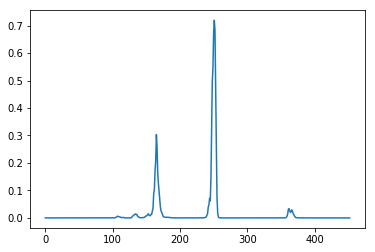

In [74]:
frames = compute_mfcc_frames(sentence, fs, shift=0.01, num_features=40)
y_pred = model.predict_proba(frames, verbose=1)
plt.plot(y_pred[:,0])

In [75]:
#np.argmax(y_pred, axis=1)

In [52]:
from sklearn.metrics import roc_curve, auc
from scipy import interp
from sklearn.preprocessing import label_binarize

In [55]:
# Binarize the output


In [56]:
y_test

array([[1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       ...,
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0]])

In [57]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = len(keywords)

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
#fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
#roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


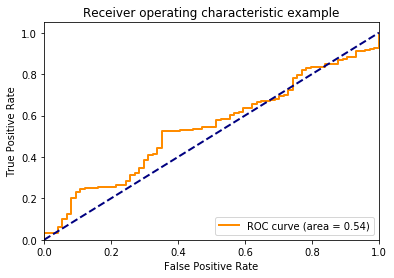

In [58]:
plt.figure()
lw = 2
plt.plot(fpr[0], tpr[0], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[0])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

100%|██████████| 1142/1142 [22:00<00:00,  1.16s/it]
/usr/local/lib/python3.5/dist-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


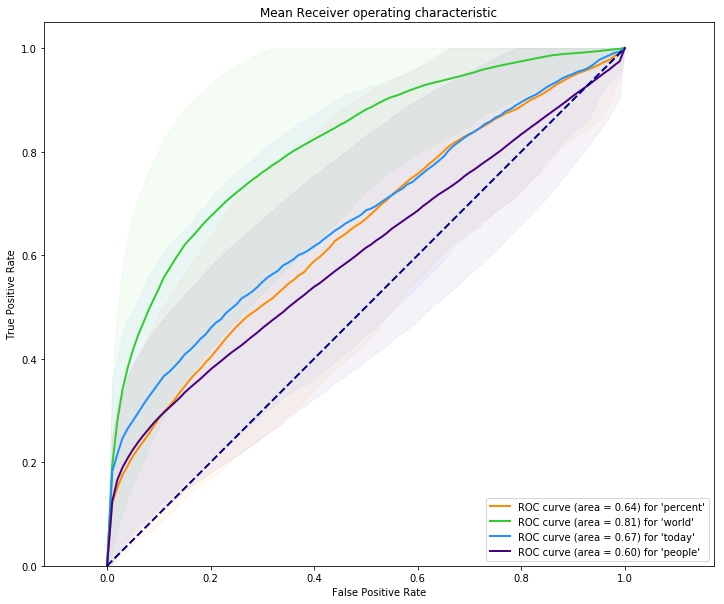

In [111]:
#tprs = []
tprs = dict()
base_fpr = np.linspace(0, 1, 101)
auc_scores = []
file_partition = create_file()
plt.figure(figsize=(12, 10))
error_files = []
classes = range(len(keywords))
fpr, tpr, auc_scores = dict(), dict(), dict()
colors = ['darkorange', 'limegreen', 'dodgerblue', 'indigo']

#test_files[:5] + test_files[-5:] + test_files[100:105] + test_files[415:420]

for file in tqdm(test_files, position=0, leave=True):
    try:
        fs, sentence, y_test = extract_sentence(path2wav_file=file, path2dataset='/aimlx/Datasets/TEDLIUM_release1/',
                                                file_partition=file_partition, duration=5, shift=0.01, percentage_kw=1.0)
        
        keyword = file.split('/')[-2]
        idx = keywords.index(keyword)
        
        y_test = label_binarize(y_test, classes=classes)
        frames = compute_mfcc_frames(sentence, fs, shift=0.01, num_features=40)
        y_pred = model.predict_proba(frames)

        fpr, tpr, _ = roc_curve(y_test[:, idx], y_pred[:, idx])
        auc_score = auc(fpr, tpr)
        if idx not in auc_scores:
            #fpr[idx] = [fpr]
            #tpr[idx] = [tpr]
            auc_scores[idx] = [auc_score]
        else:
            #fpr[idx].append(fpr)
            #tpr[idx].append(tpr)
            auc_scores[idx].append(auc_score)           
            
        #plt.plot(fpr, tpr, 'darkorange', alpha=0.05)
        tpr = interp(base_fpr, fpr, tpr)
        tpr[0] = 0.0
        if idx not in tprs:
            tprs[idx] = [tpr]
        else:
            tprs[idx].append(tpr)
        
    except IndexError as error:
        error_files.append(file)
        
for idx in tprs.keys():
    tprs[idx] = np.array(tprs[idx])
    mean_tprs = tprs[idx].mean(axis=0)
    std = tprs[idx].std(axis=0)

    tprs_upper = np.minimum(mean_tprs + std, 1)
    tprs_lower = mean_tprs - std
    plt.plot(base_fpr, mean_tprs, colors[idx], lw=2, label='ROC curve (area = %0.2f) for \'%s\'' % (np.mean(np.array(auc_scores[idx])), keywords[idx])) 
    plt.fill_between(base_fpr, tprs_lower, tprs_upper, color=colors[idx], alpha=0.05)

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0, 1.05])
plt.ylim([0, 1.05])
plt.title('Mean Receiver operating characteristic')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc="lower right")
plt.axes().set_aspect('equal', 'datalim')
plt.show()